# Indlæsning af data og kategorisering (samme som i Gruppering filen)

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

# indlæs data: husk at ændre så det passer din filplacering
mappe_sti = r"C:\Users\kftro\OneDrive - Aarhus universitet\Dataprojekt\Analyse"

# Liste over månederne (skal matche filnavnene)
maaneder = ['Jan', 'Feb', 'Mar', 'Apr', 'Maj', 'Jun', 
            'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dec']



# INDLÆS ALLE 12 MÅNEDER
alle_dataframes = []

print("Starter indlæsning af hele året...")

for m in maaneder:
    # Konstruer filnavnet: "PLC, Product detaljeret, Aarhus, Jan. 2023.xlsx"
    filnavn = f"PLC, Product detaljeret, Aarhus, {m}. 2023.xlsx"
    fuld_sti = os.path.join(mappe_sti, filnavn)
    
    if os.path.exists(fuld_sti):
        try:
            # Prøv som Excel
            temp_df = pd.read_excel(fuld_sti, header=2)
        except:
            # Fallback til CSV
            temp_df = pd.read_csv(fuld_sti, header=2, sep=';', encoding='latin1')
            
        # Gem hvilken måned data kommer fra (kan være brugbart senere)
        temp_df['Måned'] = m
        alle_dataframes.append(temp_df)
        print(f"  -> {m} indlæst.")
    else:
        print(f"  -> {m} fil mangler/kunne ikke findes.")

# Saml alt i én stor tabel
if alle_dataframes:
    df_total = pd.concat(alle_dataframes, ignore_index=True)
    print(f"\nSucces! Har samlet data for {len(df_total)} kasserede artikler.")
else:
    print("Fejl: Ingen data fundet.")
    exit()


Starter indlæsning af hele året...
  -> Jan indlæst.
  -> Feb indlæst.
  -> Mar indlæst.
  -> Apr indlæst.
  -> Maj indlæst.
  -> Jun indlæst.
  -> Jul indlæst.
  -> Aug indlæst.
  -> Sep indlæst.
  -> Okt indlæst.
  -> Nov indlæst.
  -> Dec indlæst.

Succes! Har samlet data for 248711 kasserede artikler.


In [5]:
def find_kategori(navn):
    if not isinstance(navn, str): return "Ukendt"
    navn_ren = navn.lower().replace(',', '').replace('.', '')
    
    # 1. SPECIALBEKLÆDNING (Skal fanges først!) 
    if 'term' in navn_ren: return 'Termotøj'
    if 'kedeldr' in navn_ren: return 'Kedeldragt'
    if 'overall' in navn_ren: return 'Overalls'
    
    # Flyttet op: Hvis det er kokketøj (kokkejakke/kokkebuks, osv.) fanges det her
    if 'kok' in navn_ren: return 'Kokketøj' 
    
    # 2. UNDERDELE 
    if 'underbuk' in navn_ren: return 'Underbukser'
    if any(x in navn_ren for x in ['ben', 'buks', 'jeans', 'unisexben']): return 'Bukser'
    if 'shorts' in navn_ren: return 'Shorts'
    if any(x in navn_ren for x in ['strømpe', 'sok']): return 'Sokker'
    
    # 3. OVERDELE
    if 'cardigan' in navn_ren: return 'Cardigan'
    if 'sweat' in navn_ren: return 'Sweatshirt'

    if any(x in navn_ren for x in ['t-shirt', 'tshirt']): return 'T-shirt' 

    if 'polo' in navn_ren: return 'Polo'
    if 'hætte' in navn_ren: return 'Hættetrøje'
    if 'skj' in navn_ren: return 'Skjorte'
    if 'bussero' in navn_ren: return 'Busseronne'
    if 'tunika' in navn_ren: return 'Tunika'
    if 'kit' in navn_ren: return 'Kittel'
    if 'vest' in navn_ren: return 'Vest'
    
   
    # Denne linje fanger kun jakker, der IKKE eksempelvis er kokkejakker eller termojakker. 
    if any(x in navn_ren for x in ['jak', 'jk']): return 'Jakke'
    
    if 'fleece' in navn_ren: return 'Fleece'
    if 'kasket' in navn_ren: return 'Kasket'
    
    # 4. KØKKEN & TILBEHØR
    if 'forklæde' in navn_ren or 'smæk' in navn_ren: return 'Forklæde'

    
    # Opsamling
    parts = navn_ren.split()
    if len(parts) > 1:
        return "Andet (" + parts[1].title() + ")"
    return "Andet"

# Violinplots for de N mest populære kategorier

C:\Users\kftro\AppData\Local\Temp\ipykernel_14692\2972437679.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


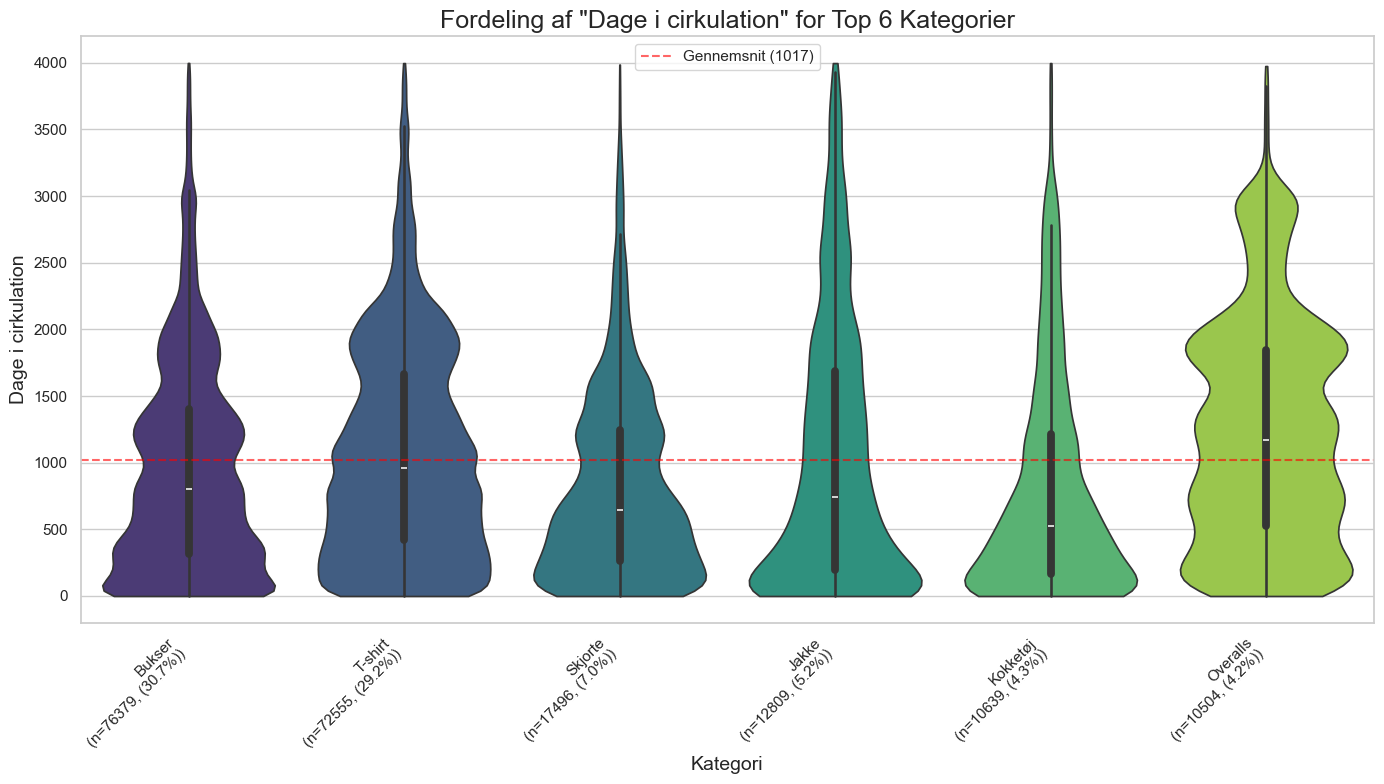

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Antal kategorier i plottet
N = 6 

# Muligheder: 'Dage i cirkulation'  ELLER  'Total antal vask'
y_akse_navn = 'Dage i cirkulation'

# Forberedelse af data - sørg for at have indlæst df_total inden
if 'Kategori' not in df_total.columns:
    df_total['Kategori'] = df_total['Produkt - Produkt'].apply(find_kategori)

# Sikre at kolonnerne er tal
cols_to_numeric = ['Dage i cirkulation', 'Total antal vask']
for col in cols_to_numeric:
    df_total[col] = pd.to_numeric(df_total[col], errors='coerce')

# Find de N mest populære kategorier
top_kategorier = df_total['Kategori'].value_counts().head(N).index
df_plot = df_total[df_total['Kategori'].isin(top_kategorier)]

# Fjern ekstreme outliers for pænere graf (skal måske tweakes lidt)
if y_akse_navn == 'Dage i cirkulation':
    grænse = 4000 # Fjern alt over ca 11 år
elif y_akse_navn == 'Total antal vask':
    grænse = 300  # Fjern alt over 300 vaske
    
df_plot = df_plot[df_plot[y_akse_navn] < grænse]

# liste af labels i samme rækkefølge som plottet - bruges til kunne plotte antal ved hver kategori
nye_labels = []
total_data_count = len(df_total) # Bruges til at beregne procent af hele datasættet
for kat in top_kategorier:
    antal = len(df_plot[df_plot['Kategori'] == kat])
    procent = (antal / total_data_count) * 100
    label = f"{kat}\n(n={antal}, ({procent:.1f}%))"
    nye_labels.append(label)

# PLOTTET
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

sns.violinplot(
    data=df_plot, 
    x='Kategori', 
    y=y_akse_navn, 
    palette="viridis", 
    cut=0,          # Skærer grafen af ved min/max data
    density_norm='width',   # Gør alle violiner lige brede for nem sammenligning
)

plt.title(f'Fordeling af "{y_akse_navn}" for Top {N} Kategorier', fontsize=18)
plt.xlabel('Kategori', fontsize=14)
plt.ylabel(y_akse_navn, fontsize=14)
plt.xticks(rotation=45, ha='right')

# Tilføj gennemsnitslinje
snit = df_plot[y_akse_navn].mean()
plt.axhline(snit, color='red', linestyle='--', alpha=0.6, label=f'Gennemsnit ({int(snit)})')
plt.legend()

plt.xticks(ticks=range(len(top_kategorier)), labels=nye_labels, rotation=45) # plot antal

plt.tight_layout()
plt.show()

# Violionplots over kassationsårsager for en bestemt kategori

C:\Users\kftro\AppData\Local\Temp\ipykernel_14692\2372470592.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


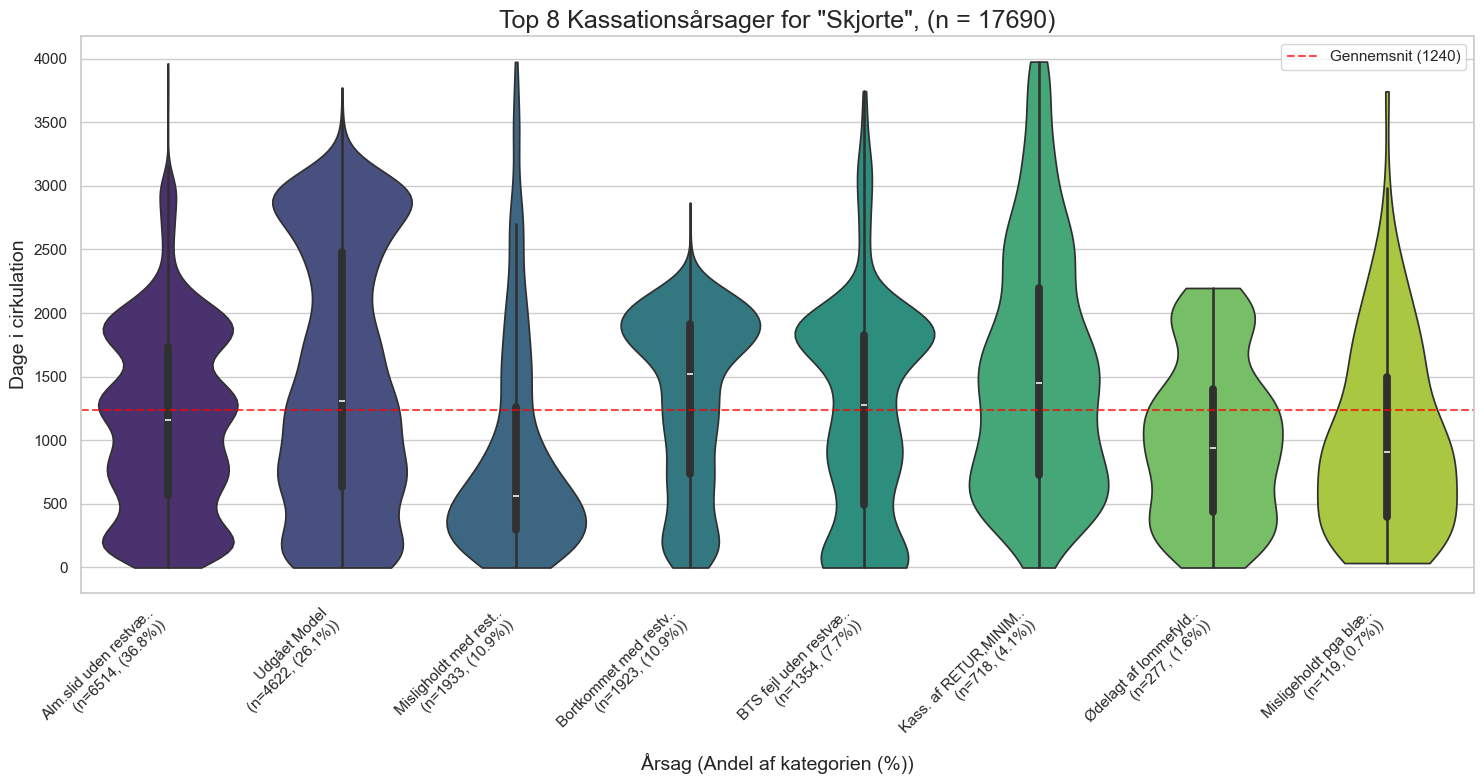

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# indstillinger
valgt_kategori = 'Skjorte'      # Kategori ('Skjorte', 'T-shirt', osv.)
N = 8                              # Antal kassationsårsager
y_akse = 'Dage i cirkulation' # 'Dage i cirkulation' eller 'Total antal vask' på y-aksen

# Filtrer på kategori
df_kat = df_total[df_total['Kategori'] == valgt_kategori]
total_kat_antal = len(df_kat) # Beregn total antal i denne kategori (til procentregning)

# Find top årsager
top_årsager = df_kat['Kassationsårsag (ui)'].value_counts().head(N).index
df_plot = df_kat[df_kat['Kassationsårsag (ui)'].isin(top_årsager)]

# Fjern outliers
limit = 4000 if y_akse == 'Dage i cirkulation' else 300
df_plot = df_plot[df_plot[y_akse] < limit]

# Antal labels
nye_labels = []
for aarsag in top_årsager:
    # Vi tæller hvor mange gange denne årsag findes i vores filtrerede datasæt
    antal = len(df_plot[df_plot['Kassationsårsag (ui)'] == aarsag])
    
    # Beregn procent af totalen for kategorien
    procent = (antal / total_kat_antal) * 100
    
    # Vi korter evt. meget lange årsagstekster af, så grafen er pænere
    kort_tekst = (aarsag[:20] + '..') if len(aarsag) > 20 else aarsag
    
    # Opdateret label med både n og %
    label = f"{kort_tekst}\n(n={antal}, ({procent:.1f}%))"
    nye_labels.append(label)

# PLOT
plt.figure(figsize=(15, 8))
sns.violinplot(
    data=df_plot, 
    x='Kassationsårsag (ui)', 
    y=y_akse, 
    order=top_årsager, # Tving rækkefølgen
    palette="viridis", 
    cut=0,
    density_norm='width'
)

plt.title(f'Top {N} Kassationsårsager for "{valgt_kategori}", (n = {total_kat_antal})', fontsize=18)
plt.ylabel(y_akse, fontsize=14)
plt.xlabel('Årsag (Andel af kategorien (%))', fontsize=14)

snit = df_plot[y_akse].mean()
plt.axhline(snit, color='red', linestyle='--', alpha=0.7, label=f'Gennemsnit ({int(snit)})')

plt.xticks(ticks=range(len(top_årsager)), labels=nye_labels, rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()

# Lavet som en funktion for at gøre det nemmere at plotte flere kategorier på en gang:

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# du kan stadig skifte mellem 'Dage i cirkulation' og 'Total antal vask' på y-akse
def lav_plot(kategori, data, y_akse='Dage i cirkulation', N=6):
    
    # Filtrer på den valgte kategori (bruger argumentet 'kategori')
    df_kat = data[data['Kategori'] == kategori]
    
    # Tjek om der overhovedet er data (hvis nu man staver forkert)
    if len(df_kat) == 0:
        print(f"Advarsel: Ingen data fundet for '{kategori}'")
        return

    total_kat_antal = len(df_kat) 

    # Find top årsager
    top_årsager = df_kat['Kassationsårsag (ui)'].value_counts().head(N).index
    df_plot = df_kat[df_kat['Kassationsårsag (ui)'].isin(top_årsager)]

    # Fjern outliers
    limit = 4000 if y_akse == 'Dage i cirkulation' else 300
    df_plot = df_plot[df_plot[y_akse] < limit]

    # Lav labels
    nye_labels = []
    for aarsag in top_årsager:
        antal = len(df_plot[df_plot['Kassationsårsag (ui)'] == aarsag])
        procent = (antal / total_kat_antal) * 100
        
        # Kort teksten af
        kort_tekst = (aarsag[:20] + '..') if len(aarsag) > 20 else aarsag
        
        # Din formatering
        label = f"{kort_tekst}\n(n={antal}, ({procent:.1f}%))"
        nye_labels.append(label)

    # --- PLOT ---
    plt.figure(figsize=(15, 8))
    sns.violinplot(
        data=df_plot, 
        x='Kassationsårsag (ui)', 
        y=y_akse, 
        order=top_årsager, 
        palette="viridis", 
        cut=0,
        density_norm='width'
    )

    plt.title(f'Top {N} Kassationsårsager for "{kategori}", (n = {total_kat_antal})', fontsize=18)
    plt.ylabel(y_akse, fontsize=14)
    plt.xlabel('Årsag (Andel af kategorien)', fontsize=14)

    snit = df_plot[y_akse].mean()
    plt.axhline(snit, color='red', linestyle='--', alpha=0.7, label=f'Gennemsnit ({int(snit)})')

    plt.xticks(ticks=range(len(top_årsager)), labels=nye_labels, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    
    # Vis plottet
    plt.show()

C:\Users\kftro\AppData\Local\Temp\ipykernel_14692\1009930379.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


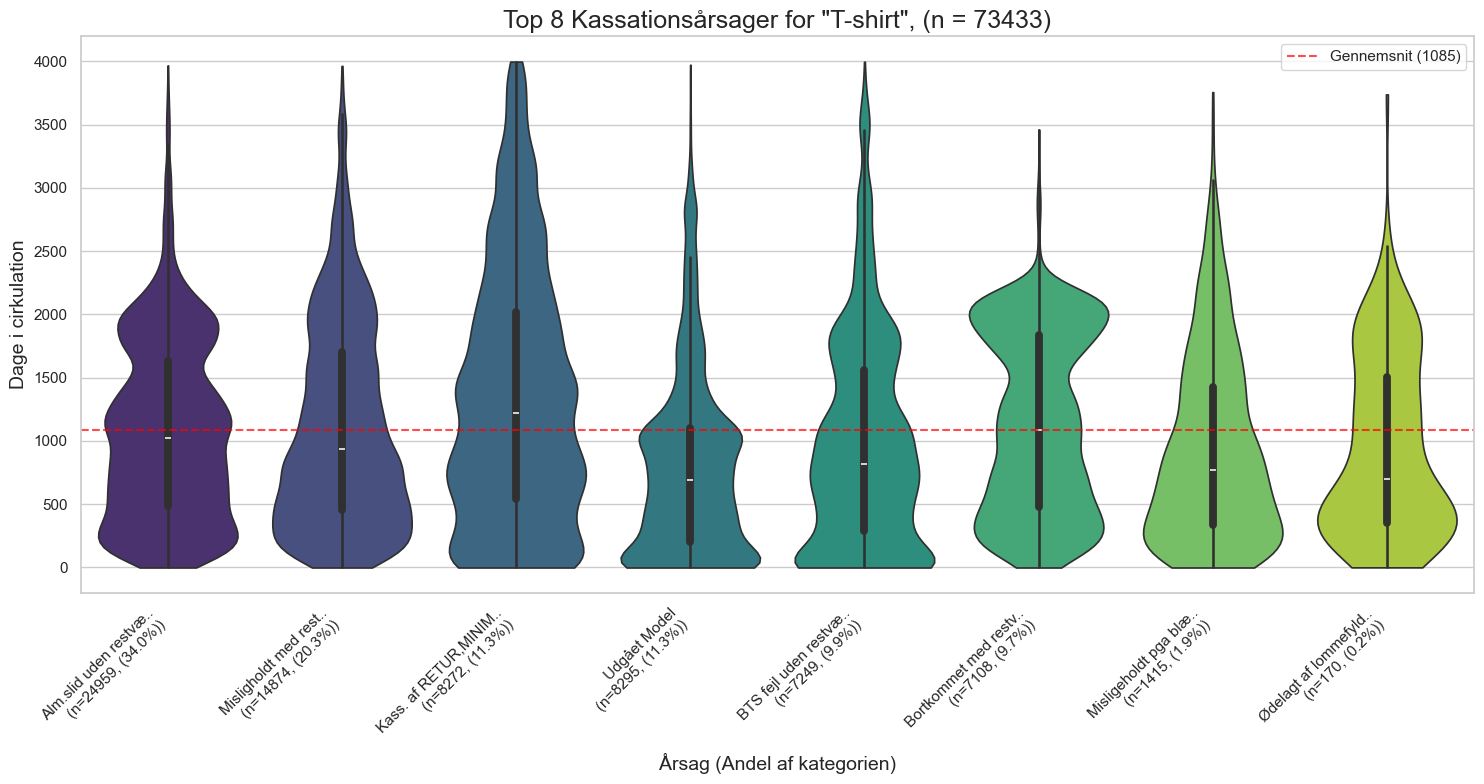

C:\Users\kftro\AppData\Local\Temp\ipykernel_14692\1009930379.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


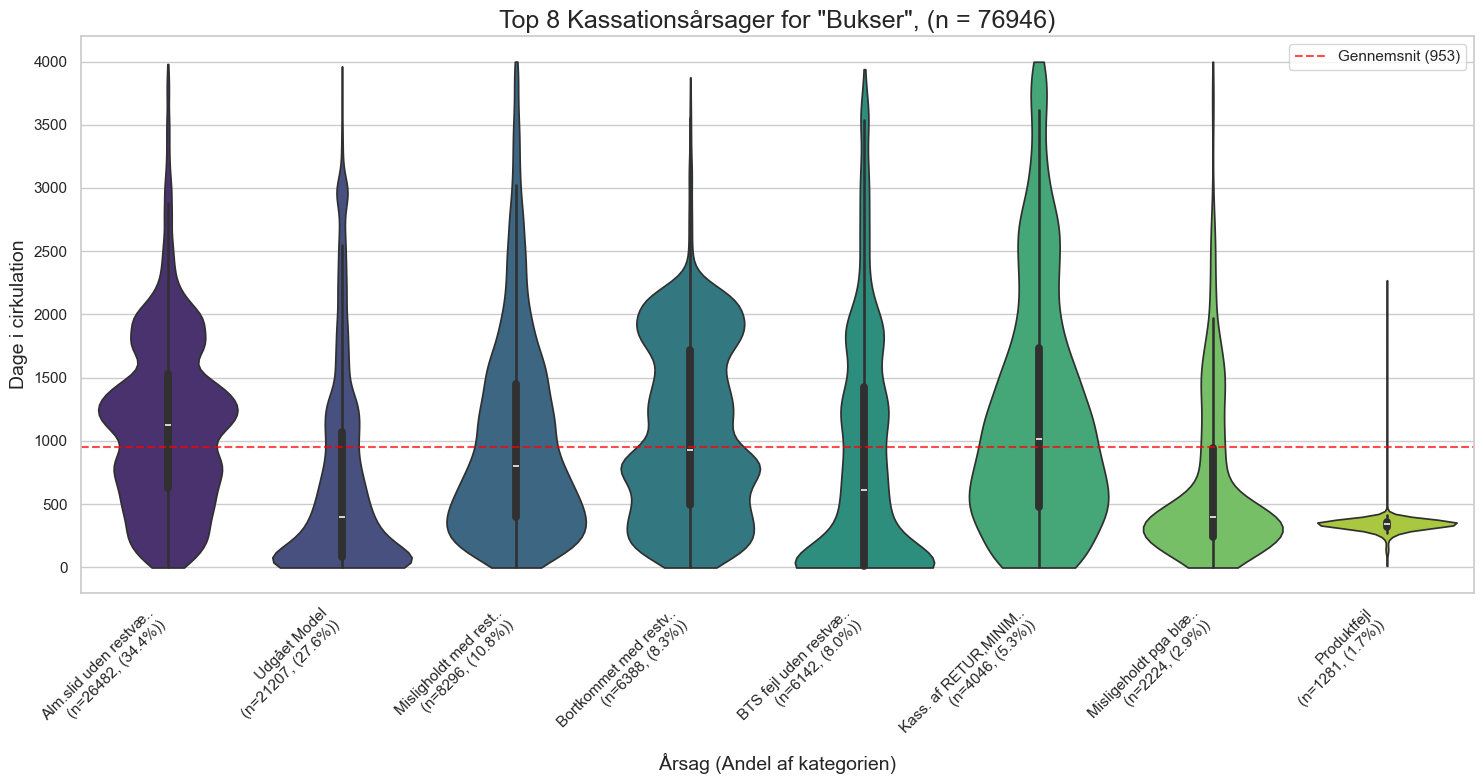

C:\Users\kftro\AppData\Local\Temp\ipykernel_14692\1009930379.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


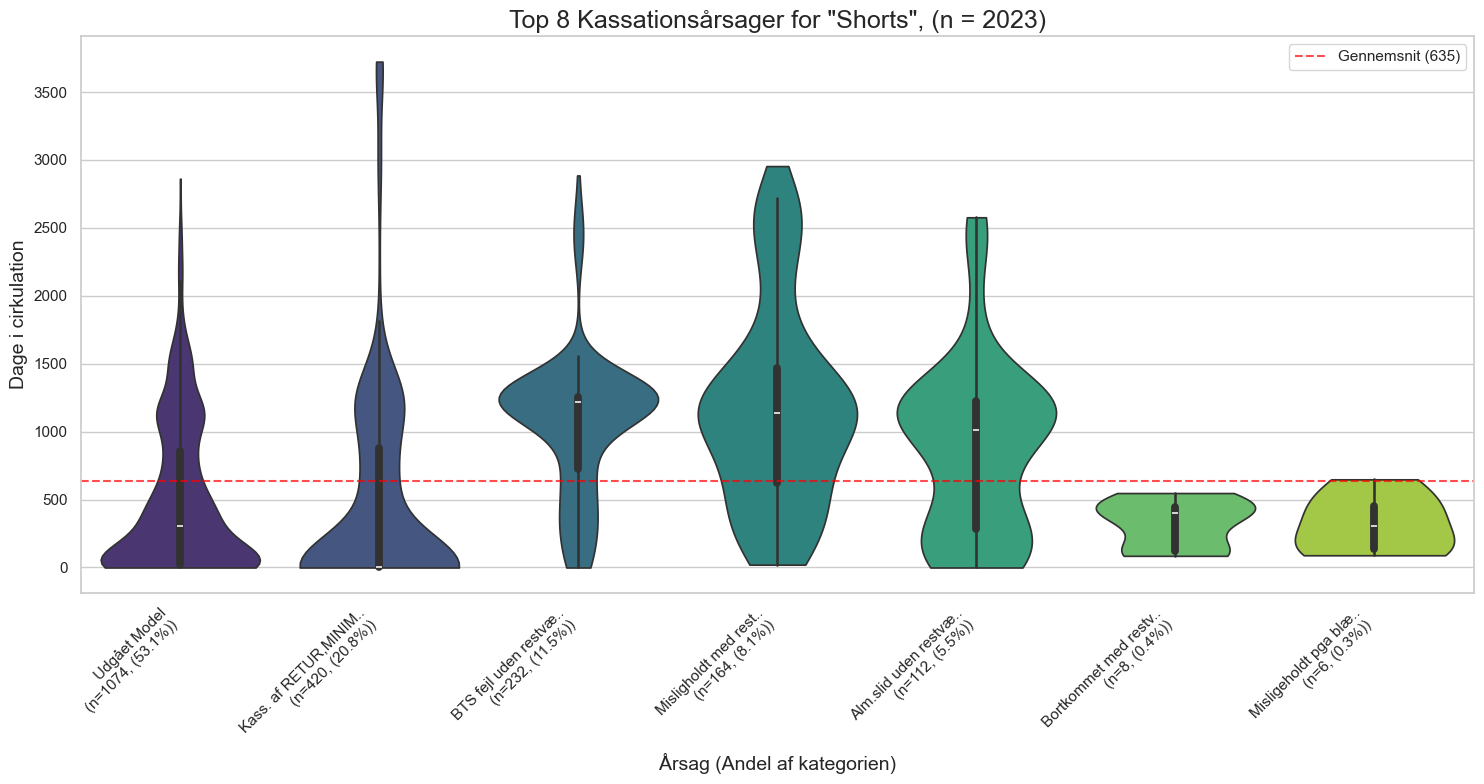

C:\Users\kftro\AppData\Local\Temp\ipykernel_14692\1009930379.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


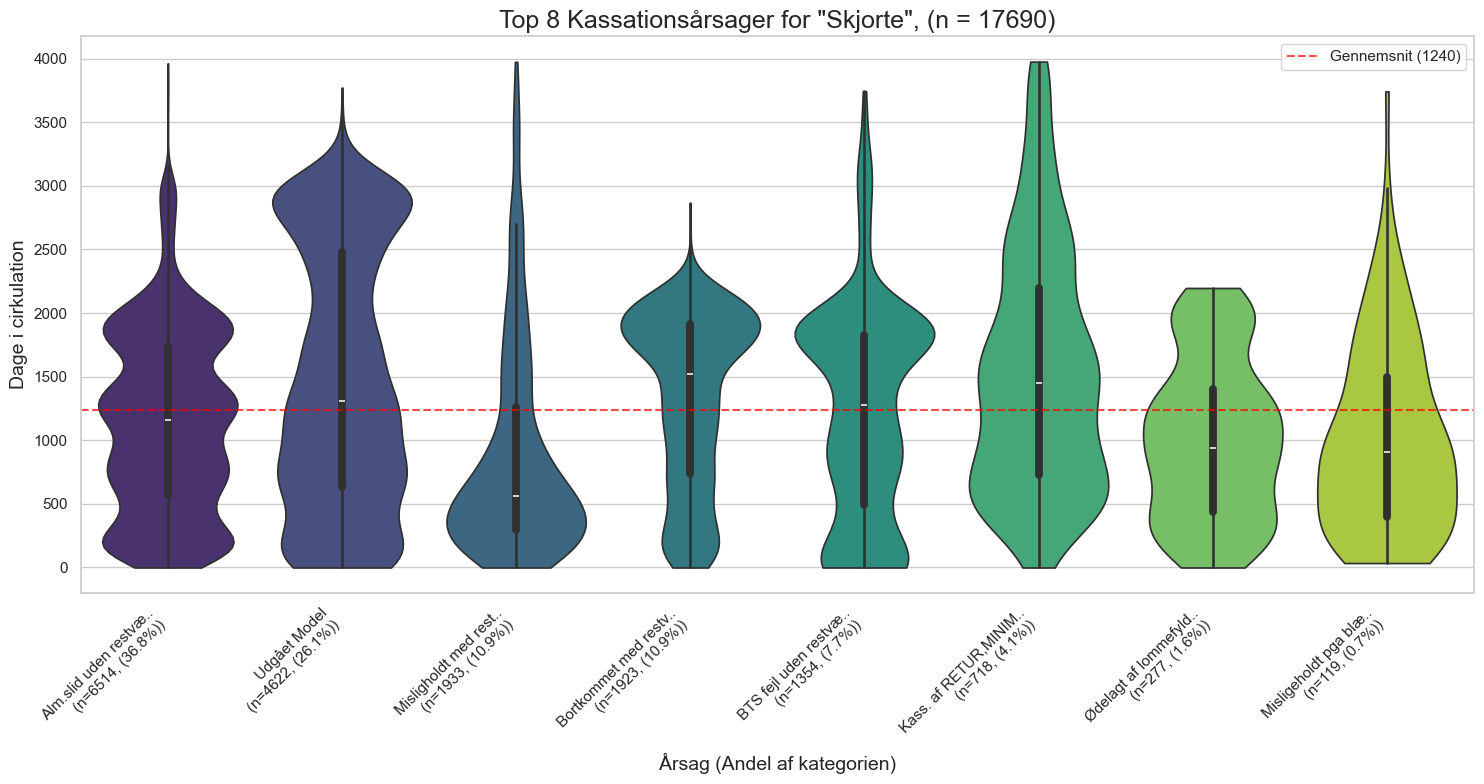

C:\Users\kftro\AppData\Local\Temp\ipykernel_14692\1009930379.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


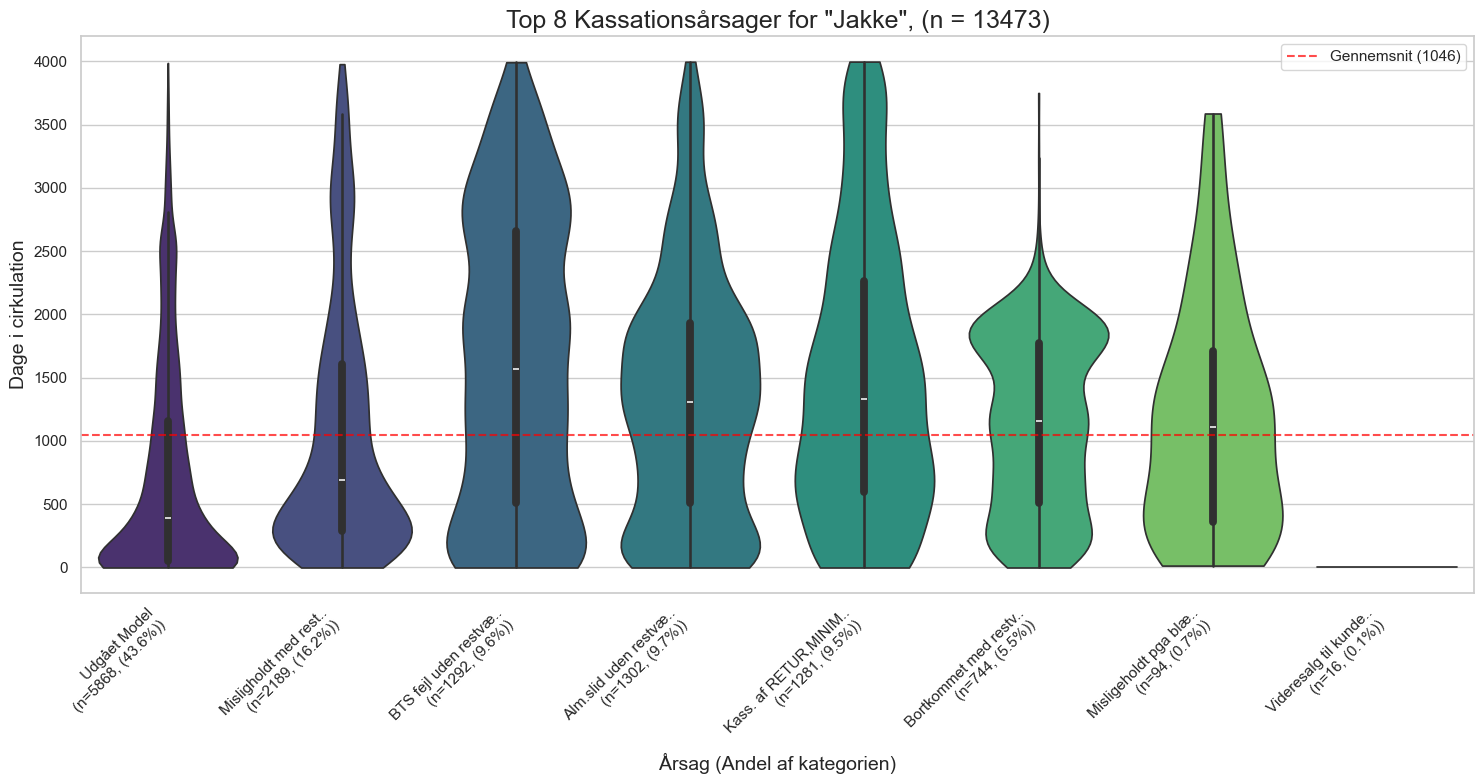

C:\Users\kftro\AppData\Local\Temp\ipykernel_14692\1009930379.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


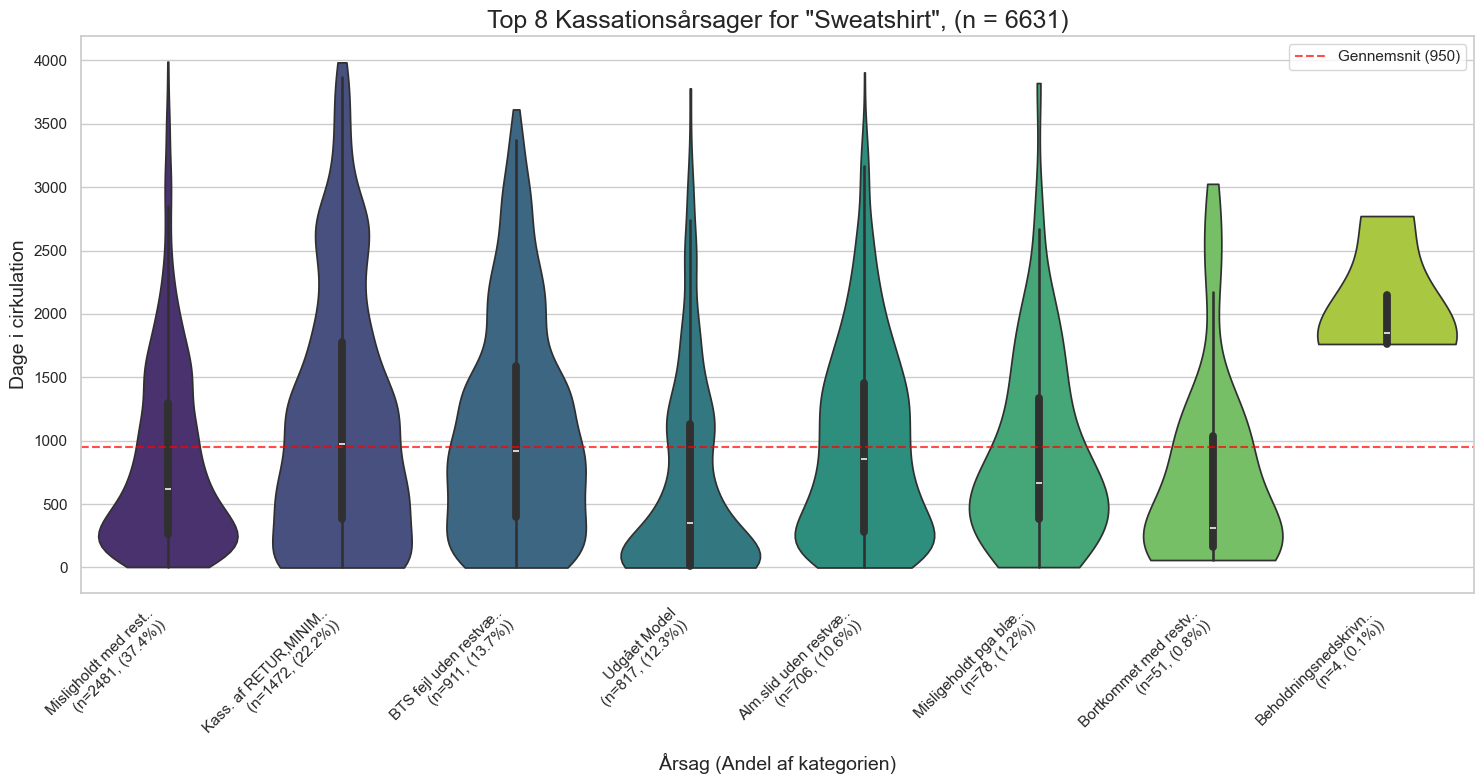

In [9]:
# KØR DET FOR MANGE KATEGORIER

# Liste over kategorier 
mine_kategorier = ['T-shirt', 'Bukser', 'Shorts', 'Skjorte', 'Jakke', 'Sweatshirt']


for kat in mine_kategorier:
    lav_plot(kat, df_total, y_akse='Dage i cirkulation', N=8)

# y_akse='Dage i cirkulation' eller y_akse='Total antal vask'

# andre ting

Genererer plots for 'T-shirt' (Top 20 årsager)...


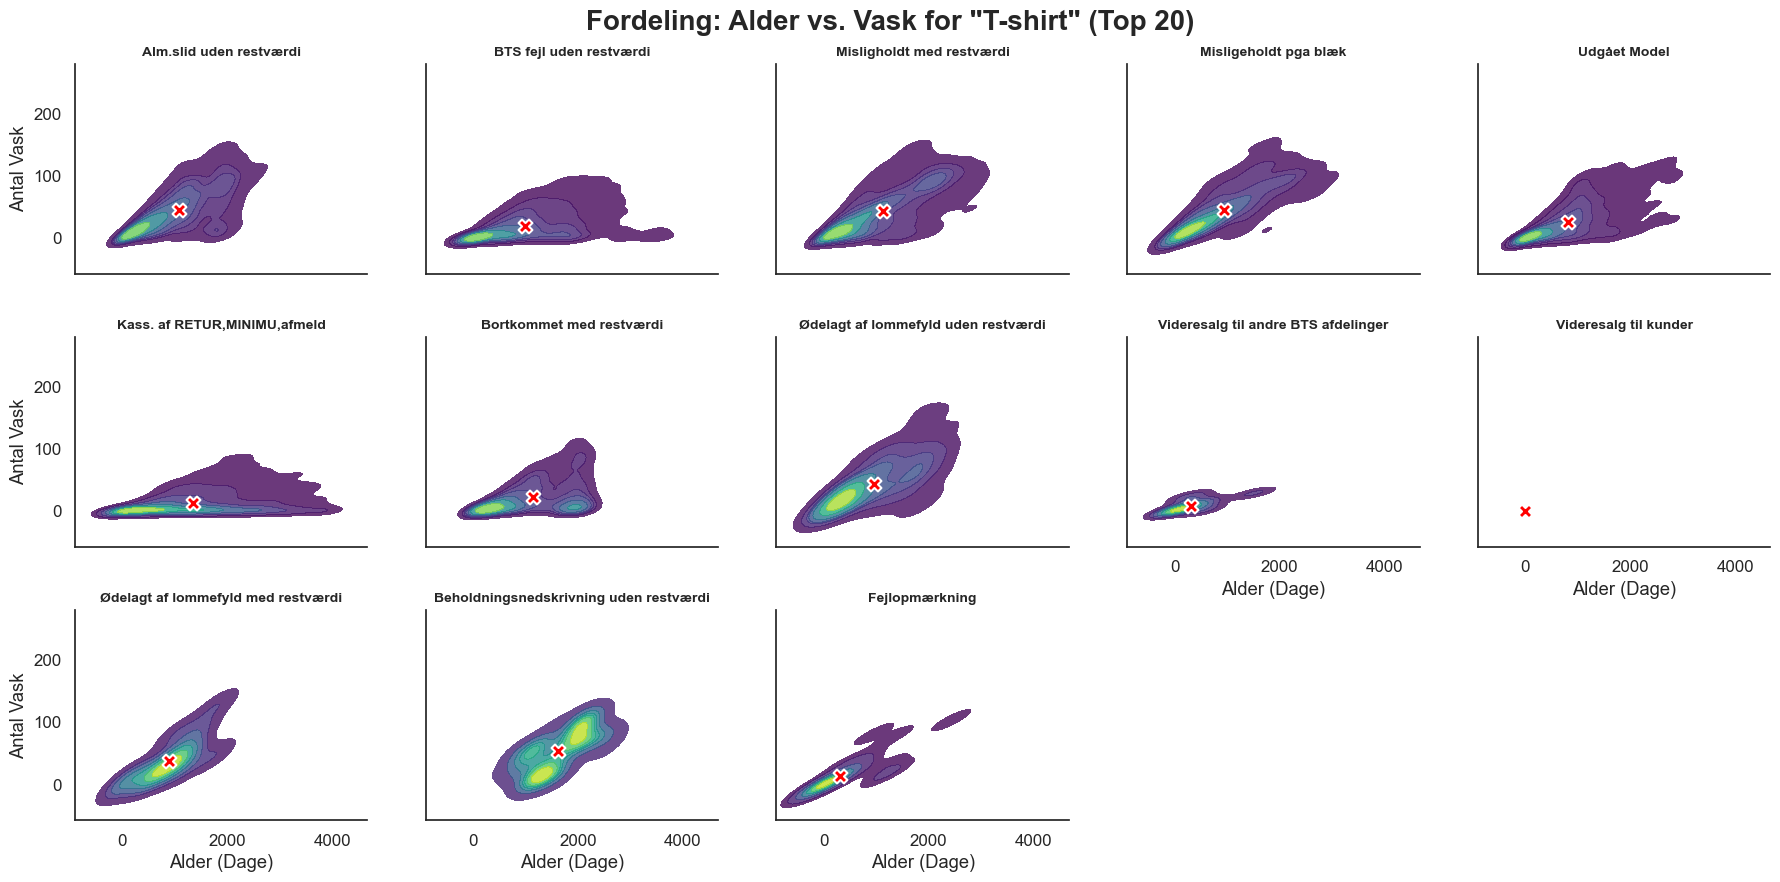

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def lav_lækre_plots(valgt_kategori, data, N_årsager=20):
    
    print(f"Genererer plots for '{valgt_kategori}' (Top {N_årsager} årsager)...")

    # 1. DATA FORBEREDELSE
    # Sørg for at vi har kategorier
    if 'Kategori' not in data.columns:
        data['Kategori'] = data['Produkt - Produkt'].apply(find_kategori)
        
    cols = ['Dage i cirkulation', 'Total antal vask']
    for c in cols:
        data[c] = pd.to_numeric(data[c], errors='coerce')

    # Filtrer på kategorien
    if valgt_kategori == 'Alle':
        df_subset = data.copy()
    else:
        df_subset = data[data['Kategori'] == valgt_kategori].copy()

    # 2. FIND DE TOP N ÅRSAGER
    top_årsager = df_subset['Kassationsårsag (ui)'].value_counts().head(N_årsager).index
    df_plot = df_subset[df_subset['Kassationsårsag (ui)'].isin(top_årsager)]

    # 3. RENS DATA (Kun for syns skyld)
    # Vi fjerner outliers i plottet, så graferne ikke bliver "mast sammen"
    df_plot = df_plot[
        (df_plot['Dage i cirkulation'] < 4000) & 
        (df_plot['Total antal vask'] < 350)
    ]
    
    # 4. FJERN ÅRSAGER MED FOR LIDT DATA
    # KDE-plots crasher, hvis der er for få punkter (f.eks. under 5). Vi filtrerer dem fra.
    counts = df_plot['Kassationsårsag (ui)'].value_counts()
    nok_data_årsager = counts[counts > 10].index
    df_plot = df_plot[df_plot['Kassationsårsag (ui)'].isin(nok_data_årsager)]

    # 5. OPSÆT PLOTTET (FacetGrid)
    sns.set_theme(style="white", font_scale=1.1) # Rent hvidt tema
    
    # col_wrap=5 betyder 5 grafer ved siden af hinanden
    g = sns.FacetGrid(df_plot, col='Kassationsårsag (ui)', col_wrap=5, height=3, aspect=1.2)

    # 6. TEGN DET "PÆNE" PLOT (KDE / KONTUR)
    # fill=True: Udfylder kurverne med farve
    # levels=8: Hvor mange "højdemeter"-streger skal der være?
    # thresh=0.05: Skjul de aller-yderste 5% (støjen), så baggrunden bliver hvid
    g.map_dataframe(
        sns.kdeplot, 
        x='Dage i cirkulation', 
        y='Total antal vask', 
        fill=True, 
        levels=8, 
        cmap="viridis", # Prøv også "mako", "rocket" eller "coolwarm"
        thresh=0.05,
        alpha=0.8       # Hvor gennemsigtig farven er
    )

    # 7. TILFØJ GENNEMSNIT (Rødt kryds)
    def plot_mean(x, y, **kwargs):
        if len(x) > 0:
            plt.scatter(x.mean(), y.mean(), color='red', s=100, marker='X', edgecolors='white', linewidths=1.5, zorder=10)
    
    g.map(plot_mean, 'Dage i cirkulation', 'Total antal vask')

    # 8. PYNT
    g.set_titles(col_template="{col_name}", fontweight='bold', size=10)
    g.set_axis_labels("Alder (Dage)", "Antal Vask")
    
    # Juster mellemrum så titlen kan være der
    g.fig.subplots_adjust(top=0.92, hspace=0.3, wspace=0.2)
    g.fig.suptitle(f'Fordeling: Alder vs. Vask for "{valgt_kategori}" (Top {N_årsager})', fontsize=20, weight='bold')

    plt.show()

# --- SÅDAN BRUGER DU DEN ---

# Sæt N til 20 (eller 15, 25 osv.)
# Vælg din kategori, fx 'Bukser', 'T-shirt' eller 'Alle'
lav_lækre_plots('T-shirt', df_total, N_årsager=20)

In [11]:
# --- FUNKTION TIL AT FINDE ABS-KODE (FRA PPT) ---
def find_abs_kode(tekst):
    if not isinstance(tekst, str): return "Ukendt"
    t = tekst.lower()
    
    # Regler baseret på beskrivelserne i din PowerPoint
    if 'bts' in t or 'af os' in t or 'fejl syning' in t: return 'AF OS'
    if 'bort' in t: return 'BORT'
    if 'retur' in t or 'afmeld' in t: return 'RETUR'
    if 'blæk' in t: return 'BLÆK'
    if 'lommefyld' in t or 'lomme' in t: return 'LOMME' # Fanger både LOMME og UC/LOMM
    if 'produkt fejl' in t or 'p.fejl' in t: return 'P.Fejl'
    if 'udgået' in t or 'udg' in t: return 'UDG'
    if 'videresalg' in t: return 'VSALGK'
    
    # VIGTIGT: Rækkefølge - "Slid" og "ITU" (Misligholdt)
    if 'slid' in t or 'almindelig brug' in t or 'farve tab' in t: return 'SLID'
    
    # ITU fanger typisk alt andet ødelagt (Huller, Pletter der ikke er blæk, etc.)
    if 'hul' in t or 'plet' in t or 'klip' in t or 'misligholdt' in t or 'itu' in t: return 'ITU'
    
    return "Andet" # Hvis intet matcher

# 1. OPRET DEN NYE KOLONNE
# (Antager du har indlæst df_total)
df_total['ABS_Kode'] = df_total['Kassationsårsag (ui)'].apply(find_abs_kode)

# Tjek at det virker
print("Fordeling af ABS-koder:")
print(df_total['ABS_Kode'].value_counts())

Fordeling af ABS-koder:
ABS_Kode
SLID      76358
UDG       55887
ITU       40347
AF OS     25023
RETUR     23221
BORT      20220
BLÆK       5142
Andet      1542
LOMME       867
VSALGK      104
Name: count, dtype: int64


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


def lav_abs_plot(kategori, aarsag_kode, data):
    print(f"Laver plot for '{kategori}' med årsagskode '{aarsag_kode}'...")
    
    # 1. FILTRER PÅ PRODUKT
    if kategori == 'Alle':
        df_sub = data.copy()
    else:
        df_sub = data[data['Kategori'] == kategori].copy()
        
    # 2. FILTRER PÅ DEN NYE ABS-KODE
    df_plot = df_sub[df_sub['ABS_Kode'] == aarsag_kode]
    
    antal = len(df_plot)
    if antal < 5:
        print(f"FEJL: Kun {antal} observationer fundet for koden '{aarsag_kode}'.")
        return

    # Fjern outliers til visning
    if x_max: df_plot = df_plot[df_plot['Dage i cirkulation'] < x_max]
    if y_max: df_plot = df_plot[df_plot['Total antal vask'] < y_max]

    # 3. PLOT
    plt.figure(figsize=(12, 10))
    sns.set_theme(style="white", font_scale=1.2)
    
    sns.kdeplot(
        data=df_plot,
        x='Dage i cirkulation',
        y='Total antal vask',
        fill=True,
        levels=15, 
        cmap="viridis", 
        thresh=0.05,
        alpha=0.8
    )
    
    # Gennemsnit
    avg_x = df_plot['Dage i cirkulation'].mean()
    avg_y = df_plot['Total antal vask'].mean()
    plt.scatter(avg_x, avg_y, color='red', s=200, marker='X', zorder=10, 
                label=f'Snit: {int(avg_x)} dage, {int(avg_y)} vask')

    plt.title(f'Analyse: "{aarsag_kode}" for "{kategori}" (n={antal})', fontsize=22, weight='bold')
    plt.xlabel('Alder (Dage)', fontsize=16)
    plt.ylabel('Antal Vaske', fontsize=16)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()




Laver plot for 'T-shirt' med årsagskode 'ITU'...


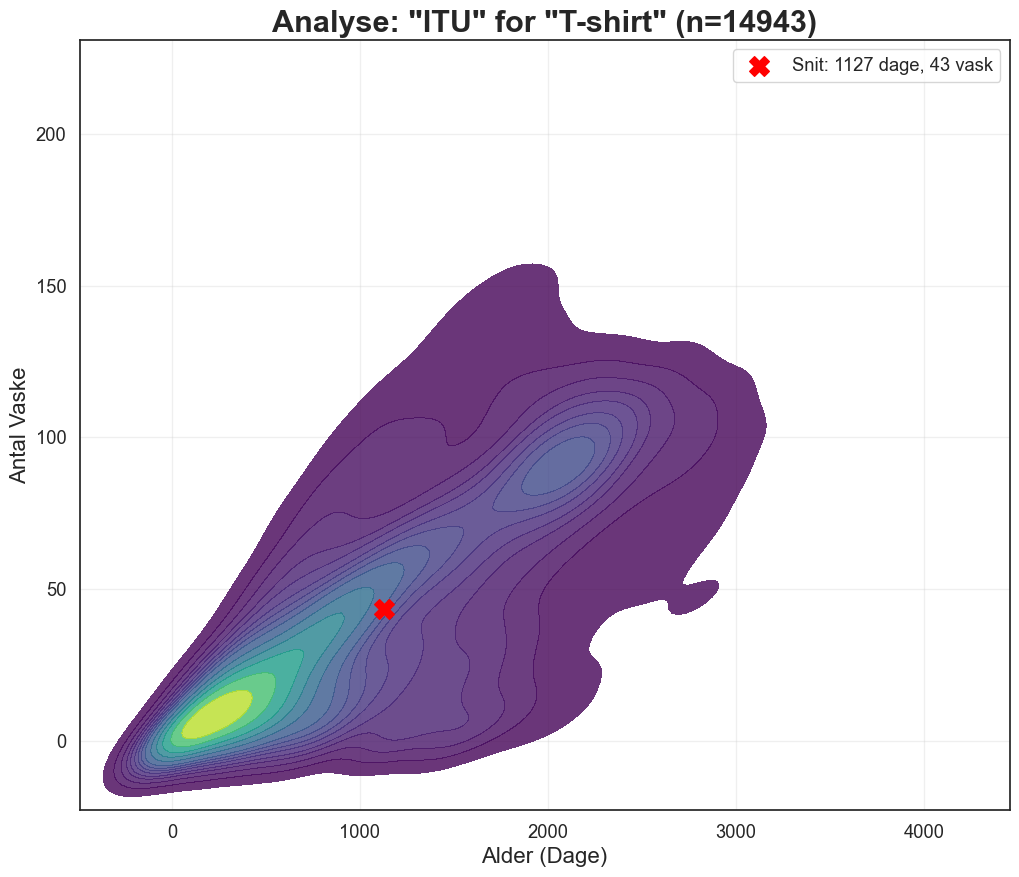

In [13]:
# --- INDSTILLINGER (Brug navnene fra "Kode i ABS") ---
valgt_kategori = 'T-shirt'   # Produktkategori
valgt_aarsag = 'ITU'       # HER KAN DU NU SKRIVE: 'SLID', 'ITU', 'AF OS' osv.

# Zoom (Sæt til None for auto)
x_max = 4000 
y_max = 300

# Kør plottet
lav_abs_plot(valgt_kategori, valgt_aarsag, df_total)

Laver Hexbin-plot for 'T-shirt' med årsag 'BLÆK'...


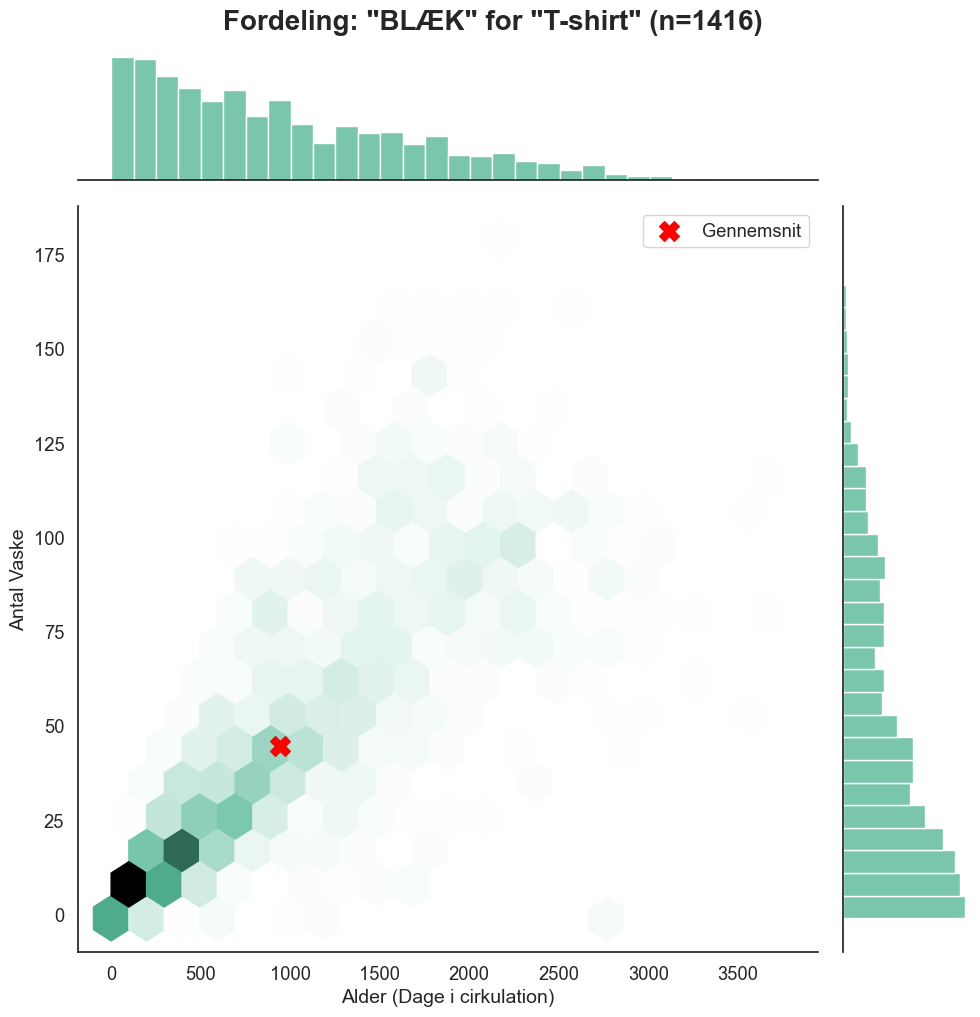

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



def lav_hexbin_plot(kategori, aarsag_kode, data):
    print(f"Laver Hexbin-plot for '{kategori}' med årsag '{aarsag_kode}'...")
    
    # 1. DATA FORBEREDELSE
    # Sørg for at ABS_Kode findes (hvis du ikke har kørt koden fra før)
    if 'ABS_Kode' not in data.columns:
        print("Genererer ABS-koder...")
        data['ABS_Kode'] = data['Kassationsårsag (ui)'].apply(find_abs_kode)

    if 'Kategori' not in data.columns:
        data['Kategori'] = data['Produkt - Produkt'].apply(find_kategori)

    # Filtrer på Kategori
    if kategori == 'Alle':
        df_sub = data.copy()
    else:
        df_sub = data[data['Kategori'] == kategori].copy()
        
    # Filtrer på Årsag
    df_plot = df_sub[df_sub['ABS_Kode'] == aarsag_kode]
    
    antal = len(df_plot)
    if antal < 10:
        print(f"FEJL: Kun {antal} observationer. Hexbin kræver mere data.")
        return

    # Fjern outliers (vigtigt for at zoome ind på det relevante)
    if x_max: df_plot = df_plot[df_plot['Dage i cirkulation'] < x_max]
    if y_max: df_plot = df_plot[df_plot['Total antal vask'] < y_max]

    # --- 2. LAV PLOTTET (JOINTPLOT) ---
    sns.set_theme(style="white", font_scale=1.2)
    
    # kind='hex' laver bikage-mønsteret
    g = sns.jointplot(
        data=df_plot,
        x='Dage i cirkulation',
        y='Total antal vask',
        kind='hex',        # Det magiske ord!
        height=10,         # Størrelse
        ratio=5,           # Forhold mellem hovedplot og side-grafer
        color="#4CB391",   # Farvetema (Prøv også "blue", "purple", "orange")
        marginal_kws=dict(bins=30, fill=True) # Indstillinger for side-graferne
    )
    
    # --- 3. PYNT OG TEKST ---
    # JointGrid er lidt specielt, man skal flytte titlen op manuelt
    g.fig.suptitle(f'Fordeling: "{aarsag_kode}" for "{kategori}" (n={antal})', fontsize=20, weight='bold', y=1.02)
    
    g.set_axis_labels('Alder (Dage i cirkulation)', 'Antal Vaske', fontsize=14)
    
    # Tilføj gennemsnit (Rødt kryds) ovenpå hex-plottet
    # Vi skal hente "ax_joint" for at tegne på hoved-plottet
    avg_x = df_plot['Dage i cirkulation'].mean()
    avg_y = df_plot['Total antal vask'].mean()
    g.ax_joint.scatter(avg_x, avg_y, color='red', s=200, marker='X', zorder=10, label='Gennemsnit')
    g.ax_joint.legend(loc='upper right')

    plt.show()

# --- INDSTILLINGER ---
valgt_kategori = 'T-shirt'  # F.eks. 'Bukser', 'T-shirt' eller 'Alle'
valgt_aarsag = 'BLÆK'      # F.eks. 'SLID', 'ITU', 'AF OS' (Husk at køre find_abs_kode først)

# Zoom (Sæt til None for auto)
x_max = 4000 
y_max = 300


# Kør funktionen
lav_hexbin_plot(valgt_kategori, valgt_aarsag, df_total)